#Mount device#

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive

[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/MyDrive


In [ ]:
!pwd

/content/drive/My Drive


#Import#

In [ ]:
from collections import Counter
import re
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import tensorflow as tf

import nltk

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from gensim.models import Word2Vec, KeyedVectors

# use these to save the model to local
#wv = api.load('word2vec-google-news-300')
#wv.save_word2vec_format('model.bin', binary=True)

#Define Constants#

In [ ]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 100 # max length of each entry (sentence), including padding
EMBEDDING_DIM = 300      # embedding dimensions for word vectors (word2vec/GloVe)

#Load Data#

In [ ]:
train = pd.read_csv('DATA/per_period/period_60.csv') #change the data folder to the period you want to train the model with
y = train['pop_class'].values
lyrics_train = train['lyrics']
lyrics_train = list(lyrics_train)

labels = [0, 1]

In [ ]:
print(len(lyrics_train))

4126


In [ ]:
texts = [] 

for line in tqdm_notebook(lyrics_train, total=59): 
    if type(line) != float:
      texts.append(line)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/59 [00:00<?, ?it/s]

In [ ]:
print('Sample data:', texts[753], y[753])

Sample data: well know problem nobody saying anybody got problem could get poppin whatever got opinion give fuck think bitch wan na get get u good nigga wan na feel fuck wisha would think gon na hit getting shit think gon na hit getting shit bitch wan na get get u good nigga wan na feel fuck wisha would think gon na hit getting shit think gon na hit getting shit throw em muthafucka bitch blanco smooth cat new jack uciano around world stacking paper hard body every city nigga slater rock gibraltar every bitch bow 0


#Tokenize#

In [ ]:
for i, ex in enumerate(texts):
  if (type(ex) == float):
    print(i, ex)

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 15340


In [ ]:
print(word_index)

{'like': 1, 'know': 2, 'oh': 3, 'got': 4, 'love': 5, 'na': 6, 'yeah': 7, 'get': 8, 'go': 9, 'time': 10, 'want': 11, 'one': 12, 'let': 13, 'baby': 14, 'come': 15, 'back': 16, 'cause': 17, 'never': 18, 'night': 19, 'feel': 20, 'see': 21, 'make': 22, 'take': 23, 'wan': 24, 'say': 25, 'way': 26, 'right': 27, 'girl': 28, 'gon': 29, 'need': 30, 'ooh': 31, 'could': 32, 'tell': 33, 'heart': 34, 'life': 35, 'thing': 36, 'day': 37, 'bitch': 38, 'keep': 39, 'nigga': 40, 'good': 41, 'think': 42, 'hey': 43, 'little': 44, 'still': 45, 'away': 46, 'look': 47, 'mind': 48, 'said': 49, 'light': 50, 'give': 51, 'eye': 52, 'every': 53, 'world': 54, 'man': 55, 'shit': 56, 'fuck': 57, 'around': 58, 'la': 59, 'ta': 60, 'home': 61, 'call': 62, 'long': 63, 'would': 64, 'hold': 65, 'nothing': 66, 'hand': 67, 'run': 68, 'boy': 69, 'better': 70, 'put': 71, 'always': 72, 'something': 73, 'well': 74, 'u': 75, 'ever': 76, 'money': 77, 'high': 78, 'find': 79, 'tonight': 80, 'head': 81, 'em': 82, 'even': 83, 'made': 8

#Padding#

In [ ]:
data = pad_sequences(sequences, padding = 'pre', maxlen = MAX_SEQUENCE_LENGTH) 
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (4126, 100)
Shape of label tensor: (4126,)


In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [ ]:
print(labels)
# convert to one hot encoding 
one_hot_labels = []
for lab in labels:
  lab_arr = [0, 0] # 0 = 1 0, 1 = 0 1
  if lab == 0:
    lab_arr[0] = 1
  else:
    lab_arr[1] = 1

  one_hot_labels.append(lab_arr)

one_hot_labels = np.array(one_hot_labels)
print(one_hot_labels[0])


[1 0 0 ... 0 0 1]
[0 1]


In [ ]:
print('Tokenized sentences: \n', data[1])
#print('Label: \n', labels[1], one_hot_labels[1])

Tokenized sentences: 
 [ 1814   811   111    37    24     6   204   163   570   158    69   612
  2816 11821   321    46   313    24     6   497   370   253  2198    42
     5   202    15    12   981     1  6606  1254   753  7642   171    12
    27     9     3     3     3    79    31    31    31    31   753  7642
   171    12    27     9     3     3     3    79    31    31    31    31
    92   233   242   233    28   233  1591  4189   173   242    91     1
  3692     8    28   101  7640    45   487    26   101    26  1620    40
  7641   378  3010    57     1   147   862     1  1381   116 11822   693
  1401   706  7643  7644]


In [ ]:
print(data.shape)
print(one_hot_labels.shape)

(4126, 100)
(4126, 2)


#Word2Vec#

In [ ]:
embeddings_index = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/model.bin', binary=True)
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in embeddings_index.vocab:
      embedding_vector = embeddings_index[word]
      embedding_matrix[i] = embedding_vector
print(" Completed!")

 Completed!


In [ ]:
print(embedding_matrix)
print(embedding_matrix.shape)

[[ 0.57601902  0.1804359   0.88827777 ...  0.46094427  0.20770098
   0.56497378]
 [ 0.10351562  0.13769531 -0.00297546 ...  0.04394531 -0.14550781
   0.07128906]
 [-0.05493164 -0.1171875   0.02783203 ... -0.18652344  0.15625
  -0.06494141]
 ...
 [ 0.07861328  0.08496094  0.02026367 ...  0.12109375 -0.06884766
   0.0300293 ]
 [ 0.29492188  0.265625   -0.11523438 ...  0.24707031 -0.20605469
  -0.07861328]
 [-0.04443359 -0.00613403  0.08642578 ... -0.09472656 -0.19042969
   0.32421875]]
(15341, 300)


In [ ]:
print(embeddings_index["oh"])

[ 7.12890625e-02  6.93359375e-02  7.56835938e-02  2.08007812e-01
 -1.22070312e-01  9.88769531e-03 -5.07812500e-02 -2.12890625e-01
  1.06445312e-01  3.22265625e-01 -2.09960938e-01 -1.60156250e-01
 -2.50000000e-01 -9.61914062e-02  4.78515625e-02  3.63281250e-01
  1.66015625e-01  1.34765625e-01 -2.02636719e-02 -5.90820312e-02
 -9.22851562e-02  4.95605469e-02  4.45312500e-01 -1.25976562e-01
  1.66015625e-01  1.31835938e-01 -8.93554688e-02  3.85742188e-02
  5.34667969e-02 -1.62109375e-01  1.44531250e-01  2.27539062e-01
 -1.52343750e-01  6.34765625e-02 -1.20117188e-01  1.35742188e-01
  7.86132812e-02  5.07812500e-02  2.10937500e-01  2.79296875e-01
  9.81445312e-02 -1.59179688e-01  3.82812500e-01 -4.68750000e-02
  1.38671875e-01 -3.66210938e-02  9.08203125e-02  7.37304688e-02
 -5.17578125e-02 -3.05175781e-02 -2.73437500e-01  2.51464844e-02
  1.47460938e-01  1.84570312e-01  8.36181641e-03  1.21093750e-01
 -1.11328125e-01  1.14257812e-01  1.34765625e-01  1.02050781e-01
 -1.14257812e-01  1.55273

In [ ]:
# Converting our labels into numpy arrays
lyrics = np.array(data)
labels = np.array(one_hot_labels)

In [ ]:
print(lyrics[:20])
print(labels[:20])

[[   0    0    0 ...   10  114  743]
 [1814  811  111 ...  706 7643 7644]
 [   0    0    0 ...   23  332   23]
 ...
 [   0    0    0 ...   35   18  166]
 [   0    0    0 ...   40  193   40]
 [   0    0    0 ...   29    6    9]]
[[0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]


#Partition the Data (train, val, test)#

In [ ]:
split_frac = 0.7 # 70% train, 30% test(val + test)
split_id = int(split_frac * len(lyrics))
train_lyrics, test_lyrics = lyrics[:split_id], lyrics[split_id:]
train_labels, test_labels = labels[:split_id], labels[split_id:]

In [ ]:
print(train_labels.shape)
print(train_lyrics.shape)

(2888, 2)
(2888, 100)


In [ ]:
split_frac = 0.5 # 50% validation, 50% test
split_id = int(split_frac * len(test_lyrics))
val_lyrics, test_lyrics = test_lyrics[:split_id], test_lyrics[split_id:]
val_labels, test_labels = test_labels[:split_id], test_labels[split_id:]

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

batch_size = 4
hidden = 8
lr=0.001
epochs = 15


train_data = TensorDataset(torch.from_numpy(train_lyrics), torch.from_numpy(train_labels))
val_data = TensorDataset(torch.from_numpy(val_lyrics), torch.from_numpy(val_labels))
test_data = TensorDataset(torch.from_numpy(test_lyrics), torch.from_numpy(test_labels))  

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
class SentimentNet(nn.Module):
    def __init__(self,
                 weight_matrix=None,
                 vocab_size=None, 
                 output_size=1,  
                 hidden_dim=512,
                 embedding_dim=400, 
                 n_layers=1,
                 dropout_prob=0.5):
      
        super(SentimentNet, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.embedding, embedding_dim = self.init_embedding(
            vocab_size, 
            embedding_dim, 
            weight_matrix)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=dropout_prob, batch_first=True)

        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = out.view(batch_size, int(out.shape[0] / batch_size), out.shape[1])
        out = out[:,-1]
        # return the output and the hidden state
        return out, hidden, lstm_out
    
    def init_embedding(self, vocab_size, embedding_dim, weight_matrix):
        # initializes the embedding
        if weight_matrix is None:
            if vocab_size is None:
                raise ValueError('If no weight matrix, need a vocab size')
            return(nn.Embedding(vocab_size, embedding_dim),
                   embedding_dim)
        else:
            # pretrained
            weights = torch.FloatTensor(weight_matrix)
            return(nn.Embedding.from_pretrained(weights),
                  weights.shape[1])
    
    def init_hidden(self, batch_size):
        # initializes the hidden state
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device),
                  torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device))
        return hidden

In [ ]:
model_params = {'weight_matrix': embedding_matrix,
                'vocab_size': len(word_index) + 1,
               'output_size': 2,
               'hidden_dim': hidden,
               'n_layers': 2,
               'embedding_dim': EMBEDDING_DIM}
               #'dropout_prob': y}
model = SentimentNet(**model_params)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
counter = 0
print_every = 10
clip = 5
valid_loss_min = np.Inf

model.train()

train_losses = []
val_losses = []
train_acc = []
val_acc = []

for i in range(epochs):
    print("Epoch")
    h = model.init_hidden(batch_size)
    train_correct = 0
    val_correct = 0
    calculated = 0
    train_loss = []
    val_loss = []
    train_count = 0
    val_count = 0

    pops = [0, 0]
    pops_gt = [0, 0]
    
    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h, lstm_out = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())

        train_loss.append(loss.item())

        for j, ex in enumerate(output):
          train_count += 1
          gt_label = torch.argmax(labels[j].float()) 
          pred_label = torch.argmax(ex.squeeze())

          pops[pred_label] += 1
          pops_gt[gt_label] += 1

          if pred_label.eq(gt_label):
            train_correct += 1

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    val_h = model.init_hidden(batch_size)
    model.eval()

    for inp, lab in val_loader:
        val_h = tuple([each.data for each in val_h])
        inp, lab = inp.to(device), lab.to(device)
        out, val_h, _ = model(inp, val_h)
        loss_val = criterion(out.squeeze(), lab.float())

        val_loss.append(loss_val.item())

        for j, ex in enumerate(out):
          val_count += 1
          gt_label = torch.argmax(lab[j].float()) 
          pred_label = torch.argmax(ex.squeeze())

          if pred_label.eq(gt_label):
            val_correct += 1
        
    model.train()

    print("Epoch: {}/{}".format(i+1, epochs),
          "Loss: {:.6f}".format(np.mean(train_loss)),
          "Val Loss: {:.6f}".format(np.mean(val_loss)),
          "Acc: {:.6f}".format(train_correct/train_count),
          "Val Acc: {:.6f}".format(val_correct/val_count))
    print(train_correct)
    print(train_count)
    
    if np.mean(val_loss) <= valid_loss_min:
        torch.save(model.state_dict(), './state_dict_' + str(EMBEDDING_DIM) + '.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model.'.format(valid_loss_min,np.mean(val_loss)))
        valid_loss_min = np.mean(val_loss)

    train_losses.append(np.mean(train_loss))
    val_losses.append(np.mean(val_loss))
    train_acc.append(train_correct/train_count)
    val_acc.append(val_correct/val_count)
    print(pops)
    print(pops_gt)

Epoch
Epoch: 1/15 Loss: 0.694858 Val Loss: 0.690347 Acc: 0.510734 Val Acc: 0.530844
1475
2888
Validation loss decreased (inf --> 0.690347).  Saving model.
[2275, 613]
[1504, 1384]
Epoch
Epoch: 2/15 Loss: 0.692465 Val Loss: 0.690458 Acc: 0.524584 Val Acc: 0.542208
1515
2888
[2571, 317]
[1504, 1384]
Epoch
Epoch: 3/15 Loss: 0.688217 Val Loss: 0.686372 Acc: 0.549515 Val Acc: 0.545455
1587
2888
Validation loss decreased (0.690347 --> 0.686372).  Saving model.
[2143, 745]
[1504, 1384]
Epoch
Epoch: 4/15 Loss: 0.684626 Val Loss: 0.687919 Acc: 0.558172 Val Acc: 0.548701
1612
2888
[2190, 698]
[1504, 1384]
Epoch
Epoch: 5/15 Loss: 0.675569 Val Loss: 0.677905 Acc: 0.594529 Val Acc: 0.589286
1717
2888
Validation loss decreased (0.686372 --> 0.677905).  Saving model.
[1881, 1007]
[1504, 1384]
Epoch
Epoch: 6/15 Loss: 0.659904 Val Loss: 0.688458 Acc: 0.615997 Val Acc: 0.556818
1779
2888
[1639, 1249]
[1504, 1384]
Epoch
Epoch: 7/15 Loss: 0.646951 Val Loss: 0.692776 Acc: 0.636080 Val Acc: 0.579545
1837
28

In [ ]:
 # Loading the best model
model.load_state_dict(torch.load('./state_dict_' + str(EMBEDDING_DIM) + '.pt'))

test_losses = []
pops = [0, 0]
gt_pops = [0, 0]
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h, _ = model(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())

    for i, ex in enumerate(output):
      gt_label = torch.argmax(labels[i].float()) 
      pred_label = torch.argmax(ex.squeeze())

      pops[pred_label] += 1
      gt_pops[gt_label] += 1

      if pred_label.eq(gt_label):
        num_correct += 1

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))
print(num_correct)
print(len(test_loader.dataset))
print(pops)
print(gt_pops)

Test loss: 0.677
Test accuracy: 0.582
360
619
[401, 215]
[327, 289]


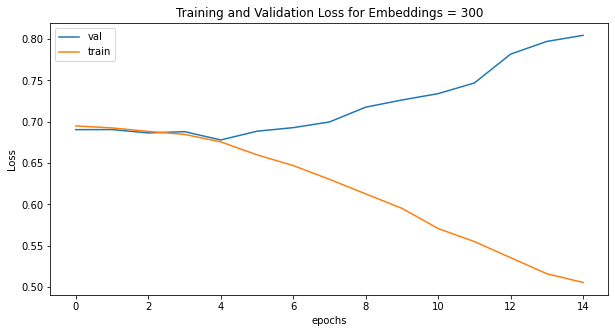

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 


plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss for Embeddings = " + str(EMBEDDING_DIM))
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("w2v_loss_pop_60.jpg")
plt.show()

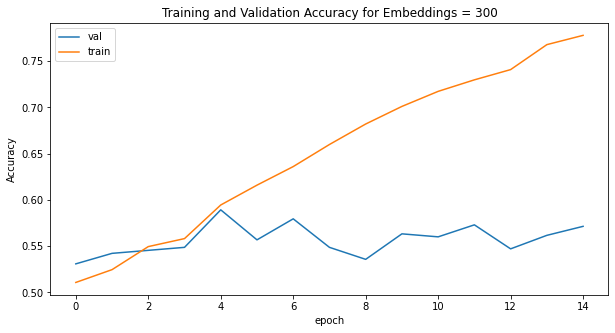

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy for Embeddings = " + str(EMBEDDING_DIM))
plt.plot(val_acc,label="val")
plt.plot(train_acc,label="train")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("w2v_acc_pop_60" + ".jpg")
plt.show()